# Projekt 2: Odkrywanie konserwatywnych wzorców w rezultatach próbkowania miejsc wiązań RNA-białko

In [67]:
import math
import os
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import stumpy
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.decomposition import PCA
from src.datasets.dataset import Dataset
from src.utils import flatten
from src.utils.flatten import flatten

1. Wybór białka (HNRNPC/HNRNPA2B1) analizowanego podczas eksperymentów, co jednoznacznie identyfikuje wykorzystywany zestaw danych.

In [68]:
protein: str = "HNRNPC"
dataset = Dataset.read(f"./resources/datasets/{protein}")

[memo::read-4c47d5...] Loading from memory.


2. Zapoznanie się z motywem oczekiwanym, wyekstrahowanym na podstawie eksperymentalnie określonej struktury 3D kompleksu, utworzonego przez analizowane białko wiążące z RNA, w celu identyfikacji liczby wchodzących w jego skład nukleotydów (len). Załóżmy, że nasz motyw oczekiwany to TTTT, wtedy len = 4.

In [20]:
dataset.pattern.fillna("N", inplace=True)
dataset.pattern

,reactivity,base
0,0.00,N
1,1.25,T
2,1.15,T
3,3.00,T
4,1.70,T
5,0.10,N


3. Określenie długości potencjalnie obiecujących motywów w = {len, len + 1, len + 2}. Załóżmy, że nasz motyw oczekiwany to TTTT (len = 4), wtedy len + 1 = {NTTTT, TTTTN}, a len + 2 = {NTTTTN}, gdzie N to dowolny nukleotyd.

In [21]:
expected_motif_length = len(dataset.pattern)
window_sizes = [expected_motif_length + x for x in range(3)]
window_sizes

[6, 7, 8]

4. Ekstrakcja wszystkich obiecujących, ciągłych motywów (reprezentowanych przez odpowiadające im profile danych fSHAPE) o długości w = len ... len + 2 spełniających założoną charakterystykę miejsca wiązania, w oparciu o wartości współczynnika reaktywności uzyskane metodą fSHAPE (tzn. wartość reaktywności dla przynajmniej jednego nukleotydu w ramach motywu musi przekraczać wartość 1.0), spośród krótkich fragmentów transkryptów zawartych w archiwum identyfikator_wybranego_białka_binding_sites_fshape.zip, które prawdopodobnie zawierają nieodkryte dotąd miejsca wiązań RNA z rozpatrywanym białkiem.

In [22]:
dataset.sites[0].head()

,reactivity,base,filename
0,0.177785,T,fshape_6
1,-0.116574,G,fshape_6
2,-0.468132,G,fshape_6
3,0.139220,G,fshape_6
4,0.222051,G,fshape_6


In [23]:
def is_motif_promising(window: pd.Series) -> bool:
    return not window.isnull().any() and (window > 1).any()

In [24]:
promising_fshapes = defaultdict(list)
promising_motifs = defaultdict(list)

for site in dataset.sites:
    for window_size in window_sizes:
        for i in range(len(site) - window_size + 1):
            window = site.reactivity[i : i + window_size]

            if is_motif_promising(window):
                promising_fshapes[window_size].append(window.to_numpy())
                promising_motifs[window_size].append(site.base[i : i + window_size].to_numpy())

print(
    f"Example\nFshape: {promising_fshapes[window_sizes[0]][0]}\nMotif: {promising_motifs[window_sizes[0]][0]}"
)

Example
Fshape: [-0.78034479  0.16741244  0.30788965 -0.45282009  0.1161698   1.18648239]
Motif: ['C' 'T' 'T' 'G' 'G' 'C']


In [25]:
for key, value in promising_fshapes.items():
    print(f"For window size {key} there are {len(value)} promising motifs")

For window size 6 there are 667 promising motifs
For window size 7 there are 716 promising motifs
For window size 8 there are 757 promising motifs


5. Przeprowadzenie analizy skupień z wykorzystaniem przynajmniej dwóch metod (np. KMEANS++, DBSCAN, itd.) dla zbioru motywów wyekstrahowanych w poprzednim kroku dla każdej długości motywu (w) analizowanej niezależnie.

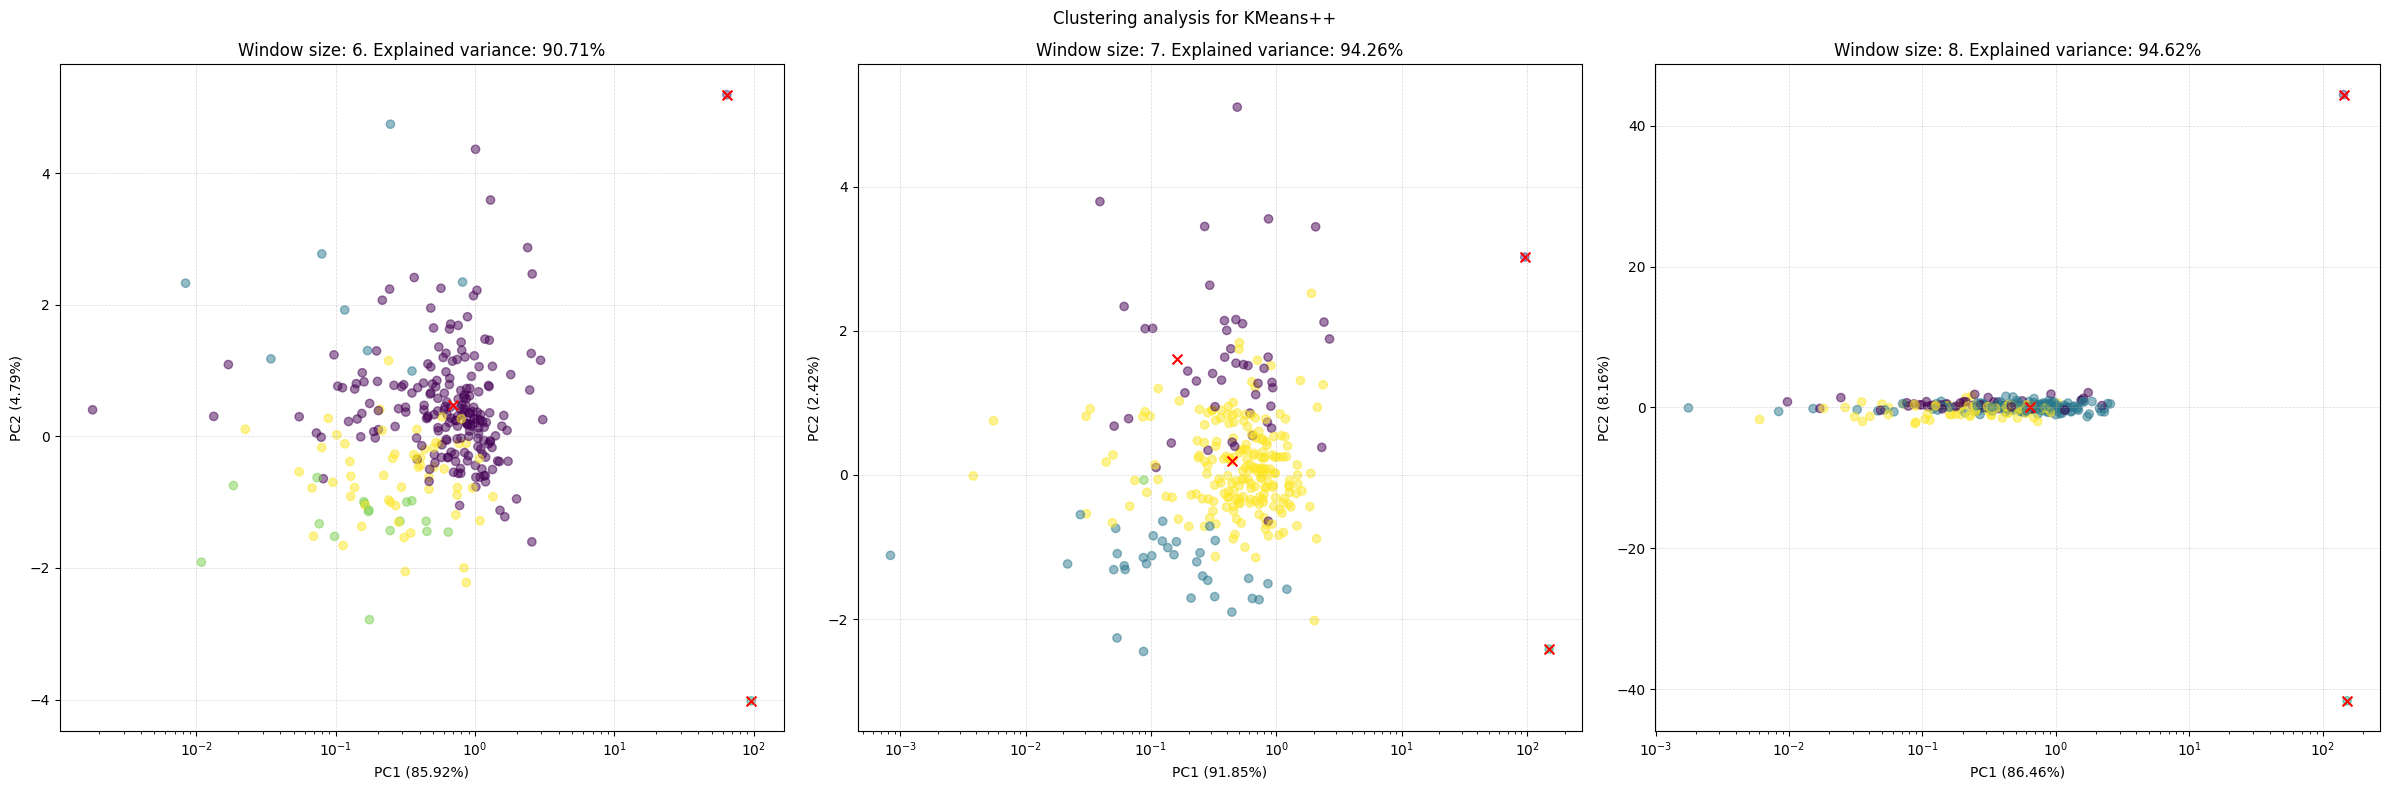

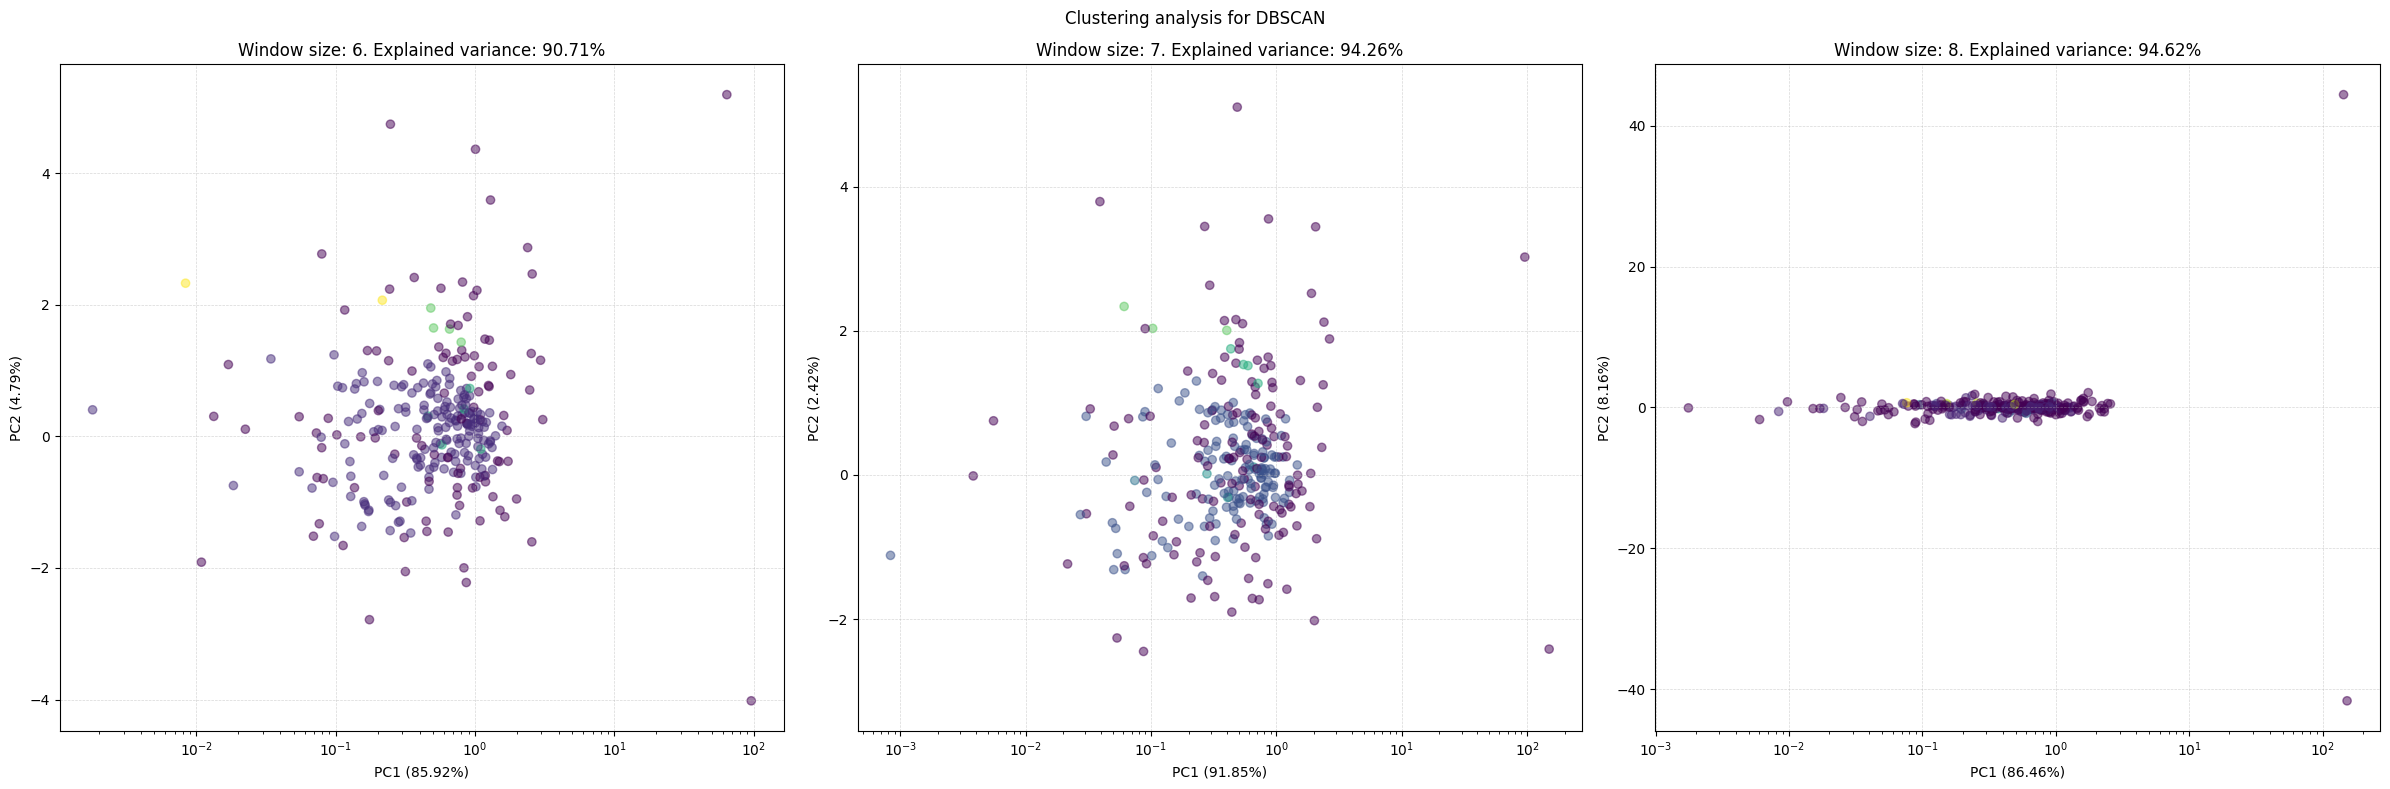

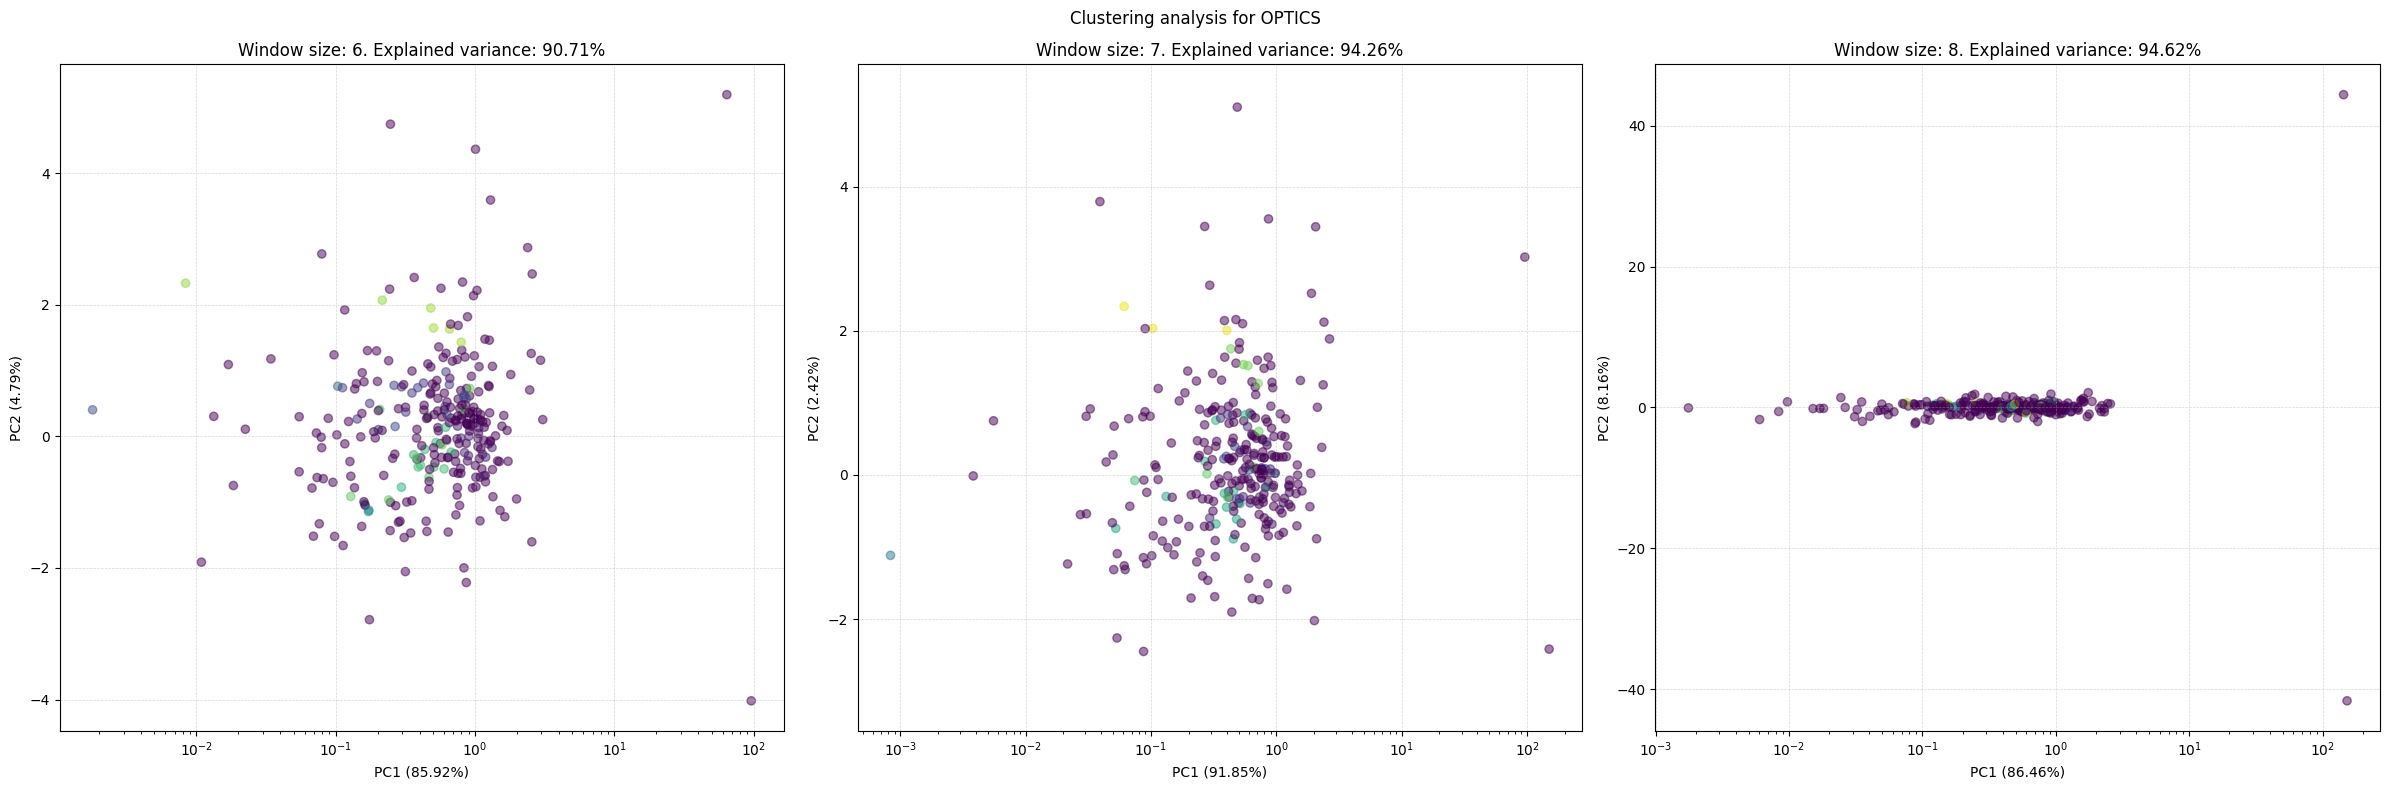

In [87]:
def perform_clustering_analysis(fshapes: defaultdict, model, name) -> None:
    fig, ax = plt.subplots(1, len(window_sizes), figsize=(24, 8), tight_layout=True)
    for i, window_size in enumerate(window_sizes):
        predicted = model.fit_predict(fshapes[window_size])
        pca = PCA(n_components=2)
        fshapes_reduced = pca.fit_transform(fshapes[window_size])

        ax[i].scatter(fshapes_reduced[:, 0], fshapes_reduced[:, 1], c=predicted, alpha=0.5)
        ax[i].set_title(
            f"Window size: {window_size}. Explained variance: {sum(pca.explained_variance_ratio_) * 100:.2f}%"
        )
        ax[i].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)")
        ax[i].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)")
        ax[i].grid(linestyle="--", linewidth=0.5, alpha=0.5)
        ax[i].set_xscale("log")

        if model.__class__.__name__ == "KMeans":
            cluster_centers = pca.transform(model.cluster_centers_)
            ax[i].scatter(
                cluster_centers[:, 0], cluster_centers[:, 1], marker="x", color="red", s=50
            )

    plt.suptitle(f"Clustering analysis for {name}")
    plt.show()


models = {
    "KMeans++": KMeans(n_clusters=6, init="k-means++", random_state=42),
    "DBSCAN": DBSCAN(eps=0.8, min_samples=3),
    "OPTICS": OPTICS(min_samples=3),
}

for name, model in models.items():
    perform_clustering_analysis(promising_fshapes, model, name)

6. Wyznaczenie obiecującego motywu konsensusowego (np. z wykorzystaniem biblioteki STUMPY) na podstawie profili danych fSHAPE zawartych w trzech najbardziej licznych klastrach zidentyfikowanych w poprzednim kroku (przy czym minimalna moc klastra, dla którego należy wyznaczać motyw konsensusowy nie może być niższa niż 3).

In [89]:
def get_most_numerous_clusters(
    predicted: np.ndarray, window_size: int, n_clusters: int = 3
) -> list:
    cluster_counts = Counter(predicted)
    cluster_counts.pop(-1, None)
    most_common_clusters = cluster_counts.most_common(n_clusters)
    print(f"Clusters for window size {window_size}: {most_common_clusters}")
    return [label for label, _ in most_common_clusters]


consensus_fshapes = [dataset.pattern.reactivity.to_numpy()]
consensus_motifs = [dataset.pattern.base.to_string(index=False).replace("\n", "")]

for window_size in window_sizes:
    fshapes = np.array(promising_fshapes[window_size])
    motifs = np.array(promising_motifs[window_size])

    predicted = models["KMeans++"].fit_predict(fshapes)
    clusters = get_most_numerous_clusters(predicted, window_size)

    for cluster in clusters:
        cluster_fshapes = fshapes[predicted == cluster].tolist()
        cluster_motifs = motifs[predicted == cluster]

        _, idx, _ = stumpy.ostinato(cluster_fshapes, window_size)
        consensus_fshapes.append(cluster_fshapes[idx])
        consensus_motifs.append("".join(cluster_motifs[idx]))

        print(f"Consensus motif for cluster {cluster}: {''.join(cluster_motifs[idx])}")

Clusters for window size 6: [(0, 226), (5, 168), (4, 159)]
Consensus motif for cluster 0: TTTTAA
Consensus motif for cluster 5: TTTGGG
Consensus motif for cluster 4: TAACTT
Clusters for window size 7: [(5, 273), (2, 226), (4, 140)]
Consensus motif for cluster 5: TATCTTT
Consensus motif for cluster 2: TTGGGAA
Consensus motif for cluster 4: TGTTGCC
Clusters for window size 8: [(5, 294), (2, 188), (0, 159)]
Consensus motif for cluster 5: AATTCTGC
Consensus motif for cluster 2: TTTTTGGT
Consensus motif for cluster 0: TTTAATTC


7. Przeprowadzenie przeszukiwania transkryptów (np. z wykorzystaniem biblioteki STUMPY), przechowywanych w archiwum identyfikator_wybranego_białka_ search_fshape.zip, na podstawie profili danych fSHAPE wyekstrahowanych dla obiecujących motywów konsensusowych zidentyfikowanych w poprzednim kroku oraz motywu oczekiwanego. Opracowanie rezultatów w postaci tabelarycznej, gdzie każdy motyw będzie opisany przez jego sekwencję, zakresy numerów nukleotydów, nazwę pliku transkryptu, w którym został zidentyfikowany oraz wartości następujących miar, a mianowicie znEd, ssf, aS wyznaczonych w kontekście motywu oczekiwanego. Rekordy powinny być uporządkowane w porządku niemalejącym według ostatniej kolumny (aS).

In [47]:
dataset.searches[0]

In [90]:
def calculate_ssf(first_motif: str, second_motif: str) -> float:
    group_matches = ("AG", "CU", "CT")
    ssf_sum: int = 0
    for first, second in zip(first_motif, second_motif):
        if first == second or first == "N" or second == "N":
            ssf_sum += 2
            continue
        for group in group_matches:
            if first in group and second in group:
                ssf_sum += 1
                break
    return ssf_sum / len(first_motif)


math.isclose(round(calculate_ssf("NTTTTN", "TGATTT"), 2), 1.33)

True

In [91]:
def get_ssf(motif: str, window_size: int) -> float:
    base = dataset.pattern.base.to_string(index=False).replace("\n", "")
    centered_base = base.center(window_size, "N")
    templates = set([centered_base, centered_base[::-1]])
    return max(calculate_ssf(motif, template) for template in templates)


def get_aS(znEd: float, ssf: float) -> float:
    return 10 * znEd - ssf


def search_through(search) -> list:
    results: list = []
    for consensus_fshape, consensus_motif in zip(consensus_fshapes, consensus_motifs):
        motif_length = len(consensus_motif)
        for i in range(len(search) - motif_length + 1):
            window = search.iloc[i : i + motif_length, :]
            znEd = stumpy.core.mass(consensus_fshape, window.reactivity)[0]

            if not is_motif_promising(window.reactivity) or znEd > 2.5:
                continue

            motif = window.base.to_string(index=False).replace("\n", "")
            ssf = get_ssf(motif, motif_length)
            aS = get_aS(znEd, ssf)

            results.append(
                {
                    "motif": consensus_motif,
                    "sequence": motif,
                    "start": i + 1,
                    "end": i + motif_length,
                    "filename": search.filename[0],
                    "znEd": znEd,
                    "ssf": ssf,
                    "aS": aS,
                }
            )

    return results

In [95]:
def parallel_search(searches) -> list:
    cores = max(1, os.cpu_count() - 1)
    fn = delayed(search_through)
    return flatten(Parallel(n_jobs=cores, verbose=10)(fn(search) for search in searches))


results = parallel_search(dataset.searches)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   13.0s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:   28.3s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   45.1s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done  38 out of  46 | elapsed:  1.5min remaining:   18.7s
[Parallel(n_jobs=7)]: Done  43 out of  46 | elapsed:  1.6min remaining:    6.8s
[Parallel(n_jobs=7)]: Done  46 out of  46 | elapsed:  1.7min finished


In [96]:
results = pd.DataFrame(results)
frame = pd.DataFrame(results)
results.sort_values("aS", inplace=True)
results

,motif,sequence,start,end,filename,znEd,ssf,aS
22030,TTGGGAA,GACCTGG,147,153,hnrnpc_NM_002116_HLA-A,0.123464,0.714286,0.520358
1777,TAACTT,GCATCG,1276,1281,hnrnpc_NM_001632_ALPP,0.159069,1.000000,0.590694
19640,TAACTT,ACCACT,481,486,hnrnpc_NM_001017365_C4BPB,0.162522,1.000000,0.625219
10609,TAACTT,GCAGGG,91,96,hnrnpc_NM_001631_ALPI,0.134343,0.666667,0.676762
3679,TAACTT,ATGGGG,329,334,hnrnpc_NM_014220_TM4SF1,0.137205,0.666667,0.705380
...,...,...,...,...,...,...,...,...
16415,AATTCTGC,CAAATGAG,1214,1221,hnrnpc_NM_001875_CPS1,2.496174,0.500000,24.461739
16442,AATTCTGC,AATGAGGT,1549,1556,hnrnpc_NM_001875_CPS1,2.496177,0.500000,24.461769
10088,NaN T T T TNaN,AAAGGGGCAGAAGAATGG,310,327,hnrnpc_NM_001631_ALPI,2.491518,0.444444,24.470735
9184,TTTAATTC,GATAAGAA,1208,1215,hnrnpc_NM_000067_CA2,2.498094,0.500000,24.480937


In [81]:
results.to_csv(f"./resources/results/{protein}_kmeans_min5.csv", index=False)

In [97]:
frame[['znEd', 'ssf', 'aS']].describe().T

,count,mean,std,min,25%,50%,75%,max
znEd,26651.0,1.859274,0.484985,0.123464,1.546663,1.962051,2.261339,2.499978
ssf,26651.0,0.782445,0.152143,0.444444,0.666667,0.750000,0.857143,1.142857
aS,26651.0,17.810290,4.864636,0.520358,14.678654,18.836336,21.840348,24.550220
